In [19]:
# If not installed, run this cell. It is needed for the determination of the recession constant
#!pip install hydrosignatures
#!pip show hydrosignatures

In [1]:
#!pip install pygeohydro
#!pip show pygeohydro

In [2]:
# The following two lines had to be executed to correct the modifications on library dependencies that the above libraries carried out when installing
#!pip install -U --force-reinstall scipy
#!pip install matplotlib --upgrade
#!pip install aiohttp --upgrade

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as stats

import hydrosignatures as hs
from pygeohydro import NWIS

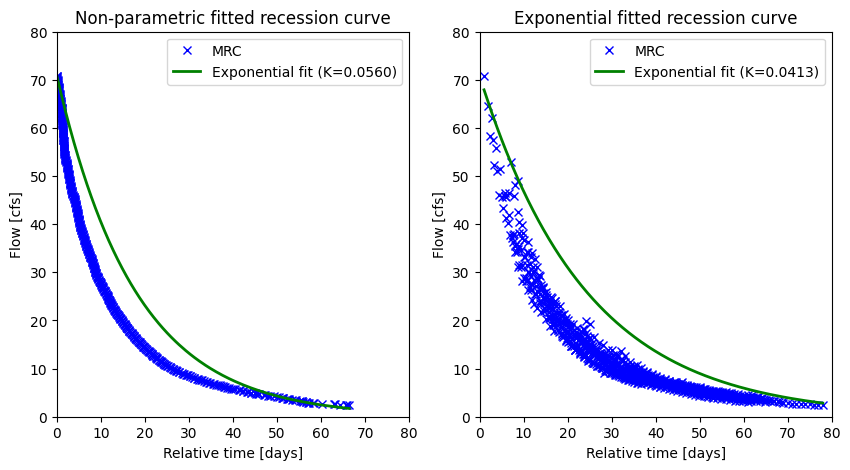

In [4]:
''' Example of how to use the baseflow recession function from the hydrosignatures library '''

# Get streamflow data
nwis = NWIS()
q = nwis.get_streamflow("12304500", ("2000-01-01", "2019-12-31"))
mrc_np, bfr_k_np = hs.baseflow_recession(q, fit_method="nonparametric_analytic")
mrc_exp, bfr_k_exp = hs.baseflow_recession(q, fit_method="exponential")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5), dpi=100)

ax1.plot(mrc_np[:, 0], mrc_np[:, 1], "bx")
ax1.plot(
    np.sort(mrc_np[:, 0]),
    np.exp(np.log(mrc_np[0, 1]) - bfr_k_np * np.sort(mrc_np[:, 0])),
    "g-",
    linewidth=2,
)
ax1.set_xlabel("Relative time [days]")
ax1.set_ylabel("Flow [cfs]")
ax1.set_xlim(0, 80)
ax1.set_ylim(0, 80)
ax1.set_title("Non-parametric fitted recession curve")
ax1.legend(["MRC", f"Exponential fit (K={bfr_k_np:.4f})"])

ax2.plot(mrc_exp[:, 0], mrc_exp[:, 1], "bx")
ax2.plot(
    np.sort(mrc_exp[:, 0]),
    np.exp(np.log(mrc_exp[0, 1]) - bfr_k_exp * np.sort(mrc_exp[:, 0])),
    "g-",
    linewidth=2,
)
ax2.set_xlabel("Relative time [days]")
ax2.set_ylabel("Flow [cfs]")
ax2.set_xlim(0, 80)
ax2.set_ylim(0, 80)
ax2.set_title("Exponential fitted recession curve")
ax2.legend(["MRC", f"Exponential fit (K={bfr_k_exp:.4f})"])

In [5]:
''' Comparion of the alpha value obtained from the example (without weights) with the alpha value obtained by using the 'polyfit' function from numpy (with weights) '''

x = list(mrc_np[:, 0])
y = list(mrc_np[:, 1])

# Fit a linear regression model
coefficients = np.polyfit(x, np.log(y), 1, w=np.sqrt(y)) # Use of weights (w) to avoid bias towards small values
beta = np.exp(coefficients[1])
alpha = coefficients[0]
print("The alpha value differs from the example ('bfr_k_np') when a weight is assigned in the 'polyfit' function:", round(alpha, 4))

# Fit a linear regression model
coefficients2 = np.polyfit(x, np.log(y), 1) # Use of weights (w) to avoid bias towards small values
beta2 = np.exp(coefficients2[1])
alpha2 = coefficients2[0]
print("The alpha value is the same value that that from the example ('bfr_k_np') when a weight is not assigned in the 'polyfit' function:", round(alpha2, 4))

The alpha value differs from the example ('bfr_k_np') when a weight is assigned in the 'polyfit' function: -0.0669
The alpha value is the same value that that from the example ('bfr_k_np') when a weight is not assigned in the 'polyfit' function: -0.056


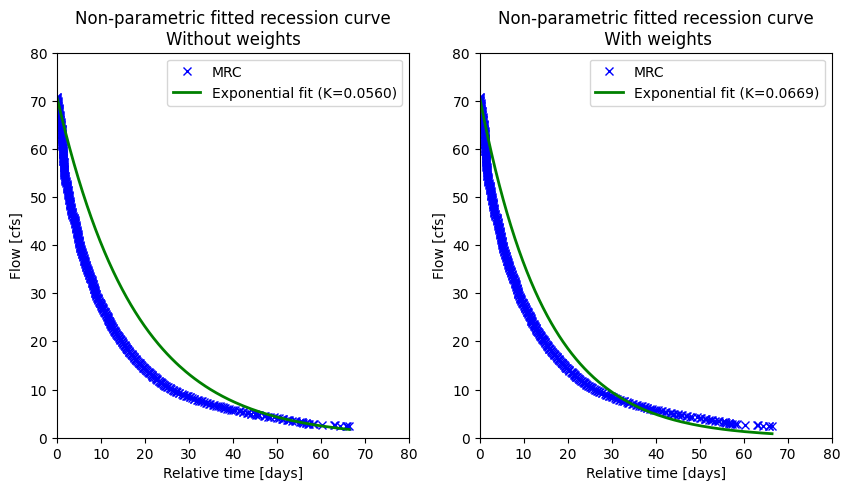

In [6]:
''' Plot of the non-parametric fitted recession curve with and without weights '''

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5), dpi=100)

ax1.plot(mrc_np[:, 0], mrc_np[:, 1], "bx")
ax1.plot(
    np.sort(mrc_np[:, 0]),
    np.exp(np.log(mrc_np[0, 1]) - abs(alpha2) * np.sort(mrc_np[:, 0])),
    "g-",
    linewidth=2,
)
ax1.set_xlabel("Relative time [days]")
ax1.set_ylabel("Flow [cfs]")
ax1.set_xlim(0, 80)
ax1.set_ylim(0, 80)
ax1.set_title("Non-parametric fitted recession curve\nWithout weights")
ax1.legend(["MRC", f"Exponential fit (K={abs(alpha2):.4f})"])

ax2.plot(mrc_np[:, 0], mrc_np[:, 1], "bx")
ax2.plot(
    np.sort(mrc_np[:, 0]),
    np.exp(np.log(mrc_np[0, 1]) - abs(alpha) * np.sort(mrc_np[:, 0])),
    "g-",
    linewidth=2,
)
ax2.set_xlabel("Relative time [days]")
ax2.set_ylabel("Flow [cfs]")
ax2.set_xlim(0, 80)
ax2.set_ylim(0, 80)
ax2.set_title("Non-parametric fitted recession curve\n With weights")
ax2.legend(["MRC", f"Exponential fit (K={abs(alpha):.4f})"])

**Coeficiente de determinación ($R^2$)**  
   - Se obtiene elevando al cuadrado el coeficiente de correlación ($R^2$), lo que significa que **no distingue entre correlaciones positivas y negativas**.  
   - Representa el **porcentaje de variabilidad** de una variable que es explicada por la otra en un modelo de regresión.  
   - Si quieres evaluar **qué tan bien un modelo explica la variabilidad de los datos**, este es el mejor indicador.

In [7]:
''' Coefficient of determination of the non-parametric fitted recession curve with and without weights '''

corr_matrix = np.corrcoef(mrc_np[:, 1], np.exp(np.log(mrc_np[0, 1]) - abs(alpha2) * np.sort(mrc_np[:, 0])))
corr = corr_matrix[0,1]
R_sq = corr**2
print("Coeffcient of determination with alpha value", abs(round(alpha2, 4)), "--without weights-- is", round(R_sq, 3))

corr_matrix2 = np.corrcoef(mrc_np[:, 1], np.exp(np.log(mrc_np[0, 1]) - abs(alpha) * np.sort(mrc_np[:, 0])))
corr2 = corr_matrix2[0,1]
R_sq2 = corr2**2
print("Coeffcient of determination with alpha value", abs(round(alpha, 4)), "--with weights-- is", round(R_sq2, 3))

Coeffcient of determination with alpha value 0.056 --without weights-- is 0.955
Coeffcient of determination with alpha value 0.0669 --with weights-- is 0.972


In [8]:
# Whole-period daily dataset
daily_folder = r"Z:\PhD_Datasets&Analysis\Info_Inputs\Streamflow_Stations\Climate_Sensitive_Stations-GRDC\2025-02-13_17-18_Daily"

# All daily continuos data folder
lcd_folder = daily_folder + "//Baseflow//longest_continuous_data"

In [9]:
# DF with the longest continuos periods for all the stations
longest_periods_df = pd.read_csv(lcd_folder + "//longest_continuos_df.csv")
longest_periods_df['Station'] = longest_periods_df['Station'].astype(str)
longest_periods_df

,Station,StartDate,EndDate,NumDays
0,3617110,1970-08-08,2016-05-27,16730
1,3617811,1983-04-21,2020-01-31,13435
2,3617812,1983-03-22,2010-10-30,10085
3,3617814,1993-10-01,2019-09-30,9496
4,3618051,1977-08-10,2017-04-30,14509
...,...,...,...,...
805,6854601,1961-01-01,1999-04-30,13999
806,6854713,1958-01-01,2020-06-24,22821
807,6855411,1975-01-01,2023-12-31,17897
808,6855412,1975-01-01,2017-08-07,15560


In [10]:
# Read the DF with all the daily data
df_cleaned = pd.read_csv(daily_folder + "\_DataFrames\Joined_Daily_Sts_DFs.csv", index_col="YYYY-MM-DD")
df_cleaned.index = pd.to_datetime(df_cleaned.index, format='%Y-%m-%d')
df_cleaned

,3617110,3617811,3617812,3617814,3618051,3618052,3618500,3618700,3618711,3618720,...,6742701,6744200,6744500,6830101,6830103,6854601,6854713,6855411,6855412,6870640
YYYY-MM-DD,,,,,,,,,,,,,,,,,,,,,
1958-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,62.2,59.0,NaN,NaN,NaN,2.20,NaN,NaN,NaN
1958-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,67.1,54.4,NaN,NaN,NaN,2.10,NaN,NaN,NaN
1958-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,77.4,54.4,NaN,NaN,NaN,2.10,NaN,NaN,NaN
1958-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,67.1,41.8,NaN,NaN,NaN,2.00,NaN,NaN,NaN
1958-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,60.6,32.8,NaN,NaN,NaN,2.00,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,2.15,6.27,7.99,2.45,1.09,7.16,10.34
2023-12-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,2.12,6.13,7.91,2.44,1.08,7.08,10.23
2023-12-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,2.10,5.90,7.84,2.41,1.07,7.01,10.15


**"hs.baseflow_recession()"**: Calculate baseflow recession constant and master recession curve.

*Notes*\
This function is ported from the TOSSH Matlab toolbox, which is based on the following publication:

- Gnann, S.J., Coxon, G., Woods, R.A., Howden, N.J.K., McMillan H.K., 2021. TOSSH: A Toolbox for Streamflow Signatures in Hydrology. Environmental Modelling & Software. https://doi.org/10.1016/j.envsoft.2021.104983

This function calculates baseflow recession constant assuming exponential recession behaviour (Safeeq et al., 2013). Master recession curve (MRC) is constructed using the adapted matching strip method (Posavec et al., 2006).

According to Safeeq et al. (2013), K < 0.065 represent groundwater dominated slow-draining systems, K >= 0.065 represent shallow subsurface flow dominated fast draining systems.

*Parameters*
- streamflow : numpy.ndarray\
    Streamflow as a 1D array.

- freq : float, optional\
    Frequency of steamflow in number of days. Default is 1, i.e., daily streamflow.

- recession_length : int, optional\
    Minimum length of recessions [days]. Default is 15.

- n_start : int, optional\
    Days to be removed after start of recession. Default is 0.

- eps : float, optional\
    Allowed increase in flow during recession period. Default is 0.

- start_of_recession : {'baseflow', 'peak'}, optional\
    Define start of recession. Default is 'baseflow'.

- fit_method : {'nonparametric_analytic', 'exponential'}, optional\
    Method to fit mrc. Default is 'nonparametric_analytic'.

- lyne_hollick_smoothing : float, optional\
    Smoothing parameter of Lyne-Hollick filter. Default is 0.925.

*Returns*
- mrc : numpy.ndarray\
    Master Recession Curve as 2D array of [time, flow].

* bf_recession_k : float\
    Baseflow Recession Constant [1/day].

*Raises*
- ValueError\
    If no recession segments are found or if a complex BaseflowRecessionK is calculated.

In [11]:
''' Determination of alpha factor with all the daily data series '''

# Initialize an empty list to store the results
results = []

for station in df_cleaned.columns:
    print("Processing station:", station)
    
    try:
        # Attempt to calculate alpha without weights
        mrc_np, alpha_without_weights = hs.baseflow_recession(df_cleaned[station], fit_method="nonparametric_analytic")
        
        # Extract x and y values
        x = list(mrc_np[:, 0])
        y = list(mrc_np[:, 1])

        # Calculate alpha with weights
        coefficients = np.polyfit(x, np.log(y), 1, w=np.sqrt(y))
        alpha_with_weights = abs(coefficients[0])

        # Compute R^2 without weights
        corr_matrix_without_weights = np.corrcoef(y, np.exp(np.log(mrc_np[0, 1]) - alpha_without_weights * np.sort(x)))
        corr_without_weights = corr_matrix_without_weights[0, 1]
        R_sq_without_weights = corr_without_weights ** 2

        # Compute R^2 with weights
        corr_matrix_with_weights = np.corrcoef(y, np.exp(np.log(mrc_np[0, 1]) - alpha_with_weights * np.sort(x)))
        corr_with_weights = corr_matrix_with_weights[0, 1]
        R_sq_with_weights = corr_with_weights ** 2
    
    except Exception as e:
        print(f"Error processing station {station}: {e}")
        
        # Assign NaN values if an error occurs
        alpha_without_weights = np.nan
        R_sq_without_weights = np.nan
        alpha_with_weights = np.nan
        R_sq_with_weights = np.nan

    # Store results in a dictionary
    results.append({
        "station": station,
        "alpha_without_weights": alpha_without_weights,
        "R_sq_without_weights": R_sq_without_weights,
        "alpha_with_weights": alpha_with_weights,
        "R_sq_with_weights": R_sq_with_weights
    })

# Convert list of dictionaries into a DataFrame
df_results = pd.DataFrame(results)
df_results

Processing station: 3617110
Processing station: 3617811
Processing station: 3617812
Processing station: 3617814
Processing station: 3618051
Processing station: 3618052
Processing station: 3618500
Processing station: 3618700
Processing station: 3618711
Processing station: 3618720


C:\Users\jvalenciag\AppData\Local\Temp\ipykernel_22444\1835194295.py:11: UserWarning: Fewer than 10 recession segments extracted, results might not be robust.
  mrc_np, alpha_without_weights = hs.baseflow_recession(df_cleaned[station], fit_method="nonparametric_analytic")


Processing station: 3618721
Processing station: 3618722
Processing station: 3618950
Processing station: 3618951
Processing station: 3621200
Processing station: 3623100
Processing station: 3625000
Processing station: 3626000
Processing station: 3627000
Processing station: 3628400
Processing station: 3628701
Processing station: 3628900
Processing station: 3629001
Processing station: 3630600
Processing station: 3631100
Processing station: 3632400
Processing station: 3633120
Processing station: 3633123
Processing station: 3633160
Processing station: 3633180
Processing station: 3633301
Processing station: 3634150
Processing station: 3634160
Processing station: 3634320
Processing station: 3634340
Processing station: 3634350
Processing station: 3634360
Processing station: 3634370
Processing station: 3635030
Processing station: 3635035
Processing station: 3635040
Processing station: 3635041
Processing station: 3635301
Processing station: 3635310
Processing station: 3635360
Processing station: 

,station,alpha_without_weights,R_sq_without_weights,alpha_with_weights,R_sq_with_weights
0,3617110,0.021888,0.854584,0.015248,0.920066
1,3617811,0.021142,0.800283,0.015538,0.875529
2,3617812,0.014939,0.992454,0.014410,0.993313
3,3617814,0.055189,0.889827,0.061359,0.898992
4,3618051,0.026449,0.904342,0.021766,0.934505
...,...,...,...,...,...
805,6854601,0.097965,0.972785,0.108371,0.971329
806,6854713,0.078585,0.960110,0.098363,0.983230
807,6855411,0.052407,0.972772,0.061154,0.985510
808,6855412,0.052941,0.990351,0.048160,0.994991


In [12]:
df_results.describe()

,alpha_without_weights,R_sq_without_weights,alpha_with_weights,R_sq_with_weights
count,794.000000,794.000000,794.000000,794.000000
mean,0.128807,0.897045,0.194011,0.946145
std,0.091377,0.098938,0.177511,0.065776
min,0.003364,0.218907,0.003385,0.211831
25%,0.060768,0.845849,0.072034,0.926022
50%,0.112334,0.929929,0.144795,0.966284
75%,0.171071,0.972767,0.261634,0.985232
max,0.767797,0.998805,1.742496,0.998922


In [ ]:
''' Determination of alpha factor with only the longest continuous daily data periods '''

# Initialize an empty list to store the results
results2 = []

for station in df_cleaned.columns:
    print("Processing station:", station)

    # Get the start and end dates of the longest period of each station
    start_date = longest_periods_df[longest_periods_df["Station"] == station]["StartDate"].to_list()[0]
    end_date = longest_periods_df[longest_periods_df["Station"] == station]["EndDate"].to_list()[0]
    
    try:
        # Attempt to calculate alpha without weights
        mrc_np, alpha_without_weights = hs.baseflow_recession(df_cleaned.loc[start_date:end_date, [station]], fit_method="nonparametric_analytic")
        
        # Extract x and y values
        x = list(mrc_np[:, 0])
        y = list(mrc_np[:, 1])

        # Calculate alpha with weights
        coefficients = np.polyfit(x, np.log(y), 1, w=np.sqrt(y))
        alpha_with_weights = abs(coefficients[0])

        # Compute R^2 without weights
        corr_matrix_without_weights = np.corrcoef(y, np.exp(np.log(mrc_np[0, 1]) - alpha_without_weights * np.sort(x)))
        corr_without_weights = corr_matrix_without_weights[0, 1]
        R_sq_without_weights = corr_without_weights ** 2

        # Compute R^2 with weights
        corr_matrix_with_weights = np.corrcoef(y, np.exp(np.log(mrc_np[0, 1]) - alpha_with_weights * np.sort(x)))
        corr_with_weights = corr_matrix_with_weights[0, 1]
        R_sq_with_weights = corr_with_weights ** 2
    
    except Exception as e:
        print(f"Error processing station {station}: {e}")
        
        # Assign NaN values if an error occurs
        alpha_without_weights = np.nan
        R_sq_without_weights = np.nan
        alpha_with_weights = np.nan
        R_sq_with_weights = np.nan

    # Store results in a dictionary
    results2.append({
        "station": station,
        "alpha_without_weights": alpha_without_weights,
        "R_sq_without_weights": R_sq_without_weights,
        "alpha_with_weights": alpha_with_weights,
        "R_sq_with_weights": R_sq_with_weights
    })

# Convert list of dictionaries into a DataFrame
df_results2 = pd.DataFrame(results2)
df_results2

In [14]:
df_results2.describe()

,alpha_without_weights,R_sq_without_weights,alpha_with_weights,R_sq_with_weights
count,788.000000,788.000000,788.000000,788.000000
mean,0.104691,0.906464,0.143689,0.942925
std,0.080632,0.097274,0.154394,0.062825
min,0.003246,0.397577,0.003265,0.521088
25%,0.052214,0.865650,0.058608,0.923475
50%,0.085183,0.943252,0.100360,0.966317
75%,0.131916,0.977873,0.166151,0.985991
max,0.766516,0.999049,1.728502,0.999280


In [15]:
series1 = pd.Series(df_results.describe()["R_sq_with_weights"], name="ALL_DATA") # All daily data series
series2 = pd.Series(df_results2.describe()["R_sq_with_weights"], name="CONT_DATA") # Only the longest continuous daily data periods
# Concatenate the series into a DataFrame for comparison of the statistics of R2 
R_sq_mean = pd.concat([series1, series2], axis=1)
R_sq_mean

,ALL_DATA,CONT_DATA
count,794.000000,788.000000
mean,0.946145,0.942925
std,0.065776,0.062825
min,0.211831,0.521088
25%,0.926022,0.923475
50%,0.966284,0.966317
75%,0.985232,0.985991
max,0.998922,0.999280


Comparison of the **R² with weights** (`R_sq_with_weights`) values for the two datasets:  

- **ALL_DATA**: Statistics resulting from data that includes NaN values from missing data.  
- **CONT_DATA**: Statistics resulting from data that contains only the longest continuous period for each station.  

### Observations from the Comparison:
1. **Count Difference**:  
   - ALL_DATA has **794** valid values, while CONT_DATA has **788**, suggesting that for a bigger number of stations the baseflow alpha factor could not be determined when using the longest continuous period approach.  

2. **Mean & Standard Deviation**:  
   - The mean R² is slightly higher for **ALL_DATA (0.946)** than **CONT_DATA (0.943)**.  
   - The standard deviation is slightly lower for CONT_DATA, suggesting slightly more **consistency** in R² values when using continuous data.  

3. **Minimum Value**:  
   - The lowest R² in **ALL_DATA** is **0.2118**, much lower than the minimum in **CONT_DATA (0.5211)**.  
   - This suggests that **including no-data periods might have led to some very poor model fits** (possibly due to discontinuities in the hydrograph).  

4. **Median (50%) & Quartiles**:  
   - The **median** is nearly identical (**0.9663 for both**), suggesting that for most stations, the effect of using continuous data is minimal.  
   - The **interquartile range (IQR)** is also similar, indicating that most R² values are concentrated around high values (**above 0.92**).  

5. **Maximum Value**:  
   - The max R² values are nearly identical (**0.9989 vs. 0.9993**), meaning that for the best-fit cases, the difference in data selection method has no significant effect.  

### Interpretation:
- **Removing discontinuous periods seems to slightly reduce variability** (lower standard deviation).  
- **Extremely low R² values disappear** in the continuous dataset, suggesting that missing data might be **hurting model performance** for some stations.  
- **For the majority of stations**, there’s no significant difference in R², meaning that the **baseflow recession analysis is robust** whether or not small gaps in data exist.  

### Next Steps:
- You could **investigate the stations where R² dropped significantly** (e.g., check which stations had an R² < 0.5 in the ALL_DATA case but improved in CONT_DATA).

In [16]:
#### Step 1: Check Normality of Differences ####
# First, test if the differences are normally distributed using the Shapiro-Wilk test.
# If p > 0.05, the differences follow a normal distribution, and you can use a paired t-test.
# If p ≤ 0.05, the differences do not follow a normal distribution, and you should use the Wilcoxon signed-rank test instead.

# Compute the differences
differences = df_results["R_sq_with_weights"] - df_results2["R_sq_with_weights"]
differences = differences.dropna()  # Remove NaN values

# Shapiro-Wilk test for normality
shapiro_test = stats.shapiro(differences)
print("Shapiro-Wilk test p-value:", shapiro_test.pvalue)

Shapiro-Wilk test p-value: 2.3414352721655235e-28


In [17]:
#### Step 2: Perform Statistical Test ####

# Drop NaN values before performing the test
valid_data = df_results["R_sq_with_weights"].dropna()
valid_cont_data = df_results2["R_sq_with_weights"].dropna()

# Ensure both series have the same length
valid_data, valid_cont_data = valid_data.align(valid_cont_data, join='inner')

# A) If Differences Are Normally Distributed → Use Paired t-test
#t_stat, p_value = stats.ttest_rel(valid_data, valid_cont_data)
#print("Paired t-test p-value:", p_value)

# B) If Differences Are Not Normally Distributed → Use Wilcoxon Signed-Rank Test
wilcoxon_test = stats.wilcoxon(valid_data, valid_cont_data)
print("Wilcoxon test p-value:", wilcoxon_test.pvalue)

Wilcoxon test p-value: 0.0665543282354523


- **If p ≤ 0.05**, the difference is statistically significant.
- **If p > 0.05**, there is no significant difference.

---

### **Interpreting the Results**
- If **both tests give p > 0.05**, there is **no significant difference** in R² values between the two datasets.
- If **p ≤ 0.05**, the difference is **statistically significant**, meaning using the longest continuous period **impacts the R² values**.

**CONCLUSION:** Based on the analysis, it is better to use the results obtained with the longest continuous data periods (`df_results2`). One key point is that by considering these results, some very poor model fits are avoided and the selected alpha values are those that were determined from model fits with $R^2$ greater than 0.5.

In [18]:
k_recessions = df_results2[["station", "alpha_with_weights"]].copy()
k_recessions["k_recession"] = k_recessions["alpha_with_weights"].apply(lambda row: np.exp(-row))
k_recessions = k_recessions.dropna().reset_index(drop=True)
k_recessions.to_csv(lcd_folder + "//k_recessions_df.csv", index=False) # Save file for possible further analysis
k_recessions

,station,alpha_with_weights,k_recession
0,3617110,0.017949,0.982211
1,3617811,0.015452,0.984667
2,3617812,0.014188,0.985912
3,3617814,0.041248,0.959591
4,3618051,0.023204,0.977063
...,...,...,...
783,6854601,0.090336,0.913624
784,6854713,0.083828,0.919590
785,6855411,0.055751,0.945775
786,6855412,0.051699,0.949615
